<a href="https://colab.research.google.com/github/HamzaG170/1704222822_Hamza_Gencay_IstanbulunHavaKalitesininTahmini/blob/main/LSTM_Modeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0370 - val_loss: 0.0084
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0042
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 - val_lo

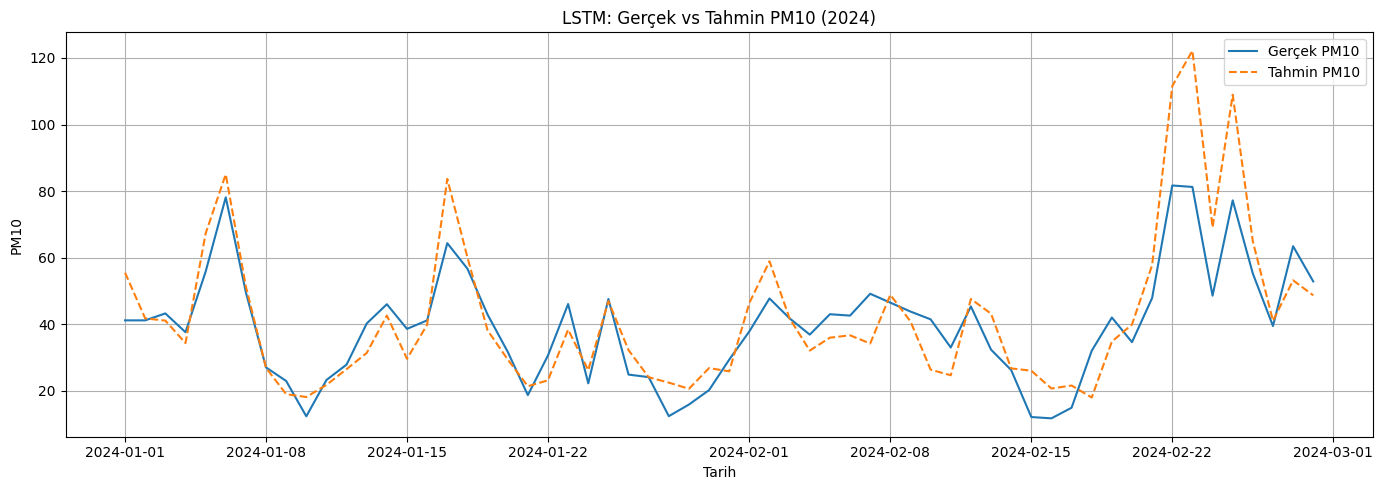

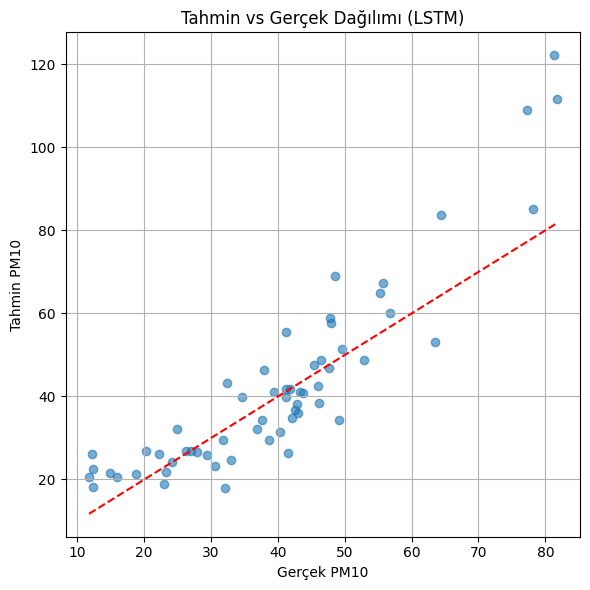

In [ ]:
# GEREKLİ KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 1. VERİYİ YÜKLE
df = pd.read_csv("veri_knn_tamamlanmis_yuvarlanmis.csv")
df["Tarih"] = pd.to_datetime(df["Tarih"])

# 2. ÖZELLİKLERİ EKLE
df["PM10_prev"] = df["PM10"].shift(1)
df["PM10_next"] = df["PM10"].shift(-1)  # sadece eğitimde kullanılacak
df["Ay"] = df["Tarih"].dt.month
df["Gun"] = df["Tarih"].dt.day

df = df.dropna().reset_index(drop=True)

# 3. GİRİŞ-ÇIKIŞ TANIMLARI
feature_columns = ["PM10_prev", "PM10_next", "SO2", "CO", "NO2", "NOX", "NO", "O3",
                   "Sıcaklık", "Nem", "Rüzgar Hızı", "Ay", "Gun"]
target_column = "PM10"

# 4. EĞİTİM VE TEST AYIRIMI
train = df[df["Tarih"] < "2024-01-01"]
test = df[df["Tarih"] >= "2024-01-01"].copy()

# TESTTE PM10_next bilinmediği için çıkar
feature_columns_test = [col for col in feature_columns if col != "PM10_next"]

X_train = train[feature_columns]
X_test_raw = test[feature_columns_test]
y_train = train[target_column]
y_test = test[target_column]

# 5. NORMALİZASYON
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)

# TEST SETİNDE PM10_next = 0 olarak yerleştir
X_test_filled = np.hstack([
    test[["PM10_prev"]].values,
    np.zeros((len(test), 1)),  # PM10_next bilinmiyor → 0
    test[["SO2", "CO", "NO2", "NOX", "NO", "O3",
          "Sıcaklık", "Nem", "Rüzgar Hızı", "Ay", "Gun"]].values
])
X_test_scaled = scaler_X.transform(X_test_filled)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 6. LSTM MODELİ
model = Sequential()
model.add(LSTM(64, input_shape=(1, len(feature_columns)), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 7. EĞİTİM
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_split=0.1, epochs=100, batch_size=32,
                    callbacks=[early_stop], verbose=1)

# 8. TEST TAHMİNİ
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 9. METRİKLER
df_results = pd.DataFrame({
    "Tarih": test["Tarih"].reset_index(drop=True),
    "Gerçek PM10": y_test.values,
    "Tahmin PM10": y_pred.flatten()
})

mae = mean_absolute_error(df_results["Gerçek PM10"], df_results["Tahmin PM10"])
rmse = np.sqrt(mean_squared_error(df_results["Gerçek PM10"], df_results["Tahmin PM10"]))
r2 = r2_score(df_results["Gerçek PM10"], df_results["Tahmin PM10"])
mape = np.mean(np.abs((df_results["Gerçek PM10"] - df_results["Tahmin PM10"]) / df_results["Gerçek PM10"])) * 100
accuracy = 100 - mape

print("\n📊 LSTM Model Performansı (2024 Test Verisi)")
print(f"MAE       = {mae:.2f}")
print(f"RMSE      = {rmse:.2f}")
print(f"R²        = {r2:.4f}")
print(f"MAPE      = {mape:.2f}%")
print(f"Doğruluk  ≈ {accuracy:.2f}%")

# 10. GRAFİKLER
plt.figure(figsize=(14,5))
plt.plot(df_results["Tarih"], df_results["Gerçek PM10"], label="Gerçek PM10")
plt.plot(df_results["Tarih"], df_results["Tahmin PM10"], label="Tahmin PM10", linestyle="--")
plt.title("LSTM: Gerçek vs Tahmin PM10 (2024)")
plt.xlabel("Tarih")
plt.ylabel("PM10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df_results["Gerçek PM10"], df_results["Tahmin PM10"], alpha=0.6)
plt.plot([df_results["Gerçek PM10"].min(), df_results["Gerçek PM10"].max()],
         [df_results["Gerçek PM10"].min(), df_results["Gerçek PM10"].max()], 'r--')
plt.title("Tahmin vs Gerçek Dağılımı (LSTM)")
plt.xlabel("Gerçek PM10")
plt.ylabel("Tahmin PM10")
plt.grid(True)
plt.tight_layout()
plt.show()


100%|██████████| 730/730 [00:45<00:00, 16.22it/s]


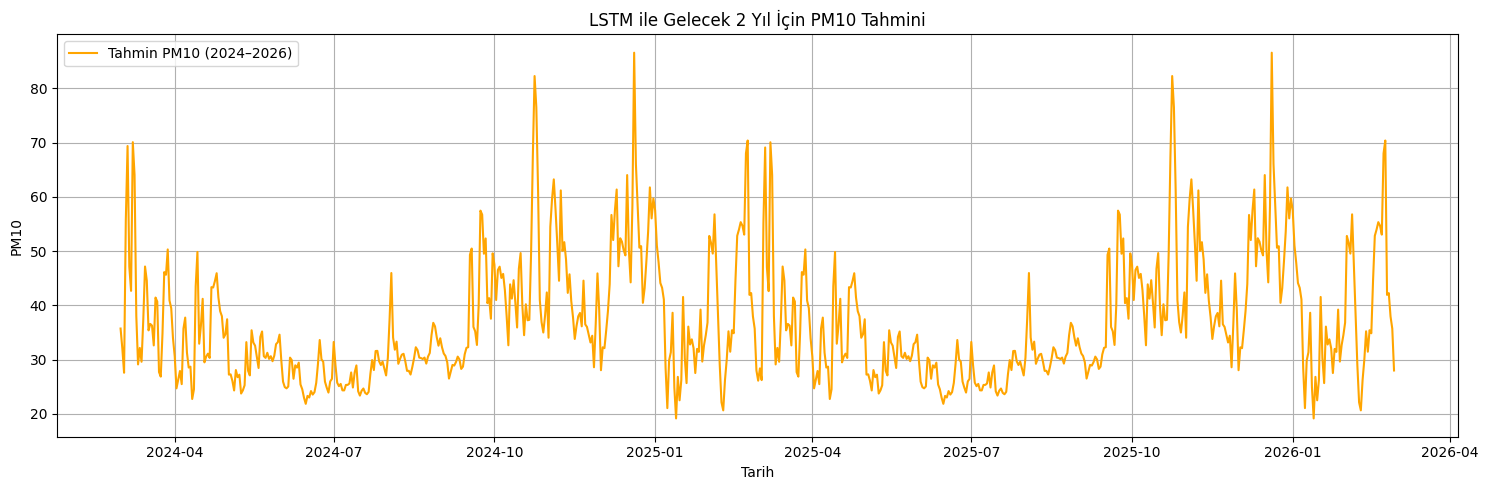

In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Ay ve Gün bilgilerini al
df["Ay"] = df["Tarih"].dt.month
df["Gun"] = df["Tarih"].dt.day

# Günlük ortalama meteorolojik ve kirletici değerleri (PM10 hariç)
mean_features_by_day = df.groupby(["Ay", "Gun"])[["SO2", "CO", "NO2", "NOX", "NO", "O3", "Sıcaklık", "Nem", "Rüzgar Hızı"]].mean()

# Son değerlerden başla
pm10_prev = df.iloc[-1]["PM10"]
last_date = df.iloc[-1]["Tarih"]

# Tahmin süresi
future_days = 730
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)
future_predictions = []

# Başlangıç girdisi
for date in tqdm(future_dates):
    ay = date.month
    gun = date.day

    try:
        others = mean_features_by_day.loc[(ay, gun)].values
    except KeyError:
        others = mean_features_by_day.mean().values

    pm10_next = 0

    # Modelin beklediği 13 özellik: [PM10_prev, PM10_next, 9 değer, Ay, Gun]
    input_features = np.concatenate([[pm10_prev, pm10_next], others, [ay, gun]]).reshape(1, -1)
    input_scaled = scaler_X.transform(input_features).reshape(1, 1, -1)

    # Tahmin et
    prediction_scaled = model.predict(input_scaled, verbose=0)
    prediction = scaler_y.inverse_transform(prediction_scaled)[0, 0]
    future_predictions.append(prediction)

    # Bir sonraki giriş için güncelle
    pm10_prev = prediction

# Sonuçları DataFrame’e aktar
df_future = pd.DataFrame({
    "Tarih": future_dates,
    "Tahmin PM10": future_predictions
})

# Kaydet ve görselleştir
df_future.to_csv("tahmin_2024_2026.csv", index=False)

plt.figure(figsize=(15, 5))
plt.plot(df_future["Tarih"], df_future["Tahmin PM10"], label="Tahmin PM10 (2024–2026)", color="orange")
plt.title("LSTM ile Gelecek 2 Yıl İçin PM10 Tahmini")
plt.xlabel("Tarih")
plt.ylabel("PM10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
print("Gerçek PM10 Özeti:")
print(df["PM10"].describe())
print("\nTahmin PM10 (Gelecek) Özeti:")
print(df_future["Tahmin PM10"].describe())


Gerçek PM10 Özeti:
count    1886.000000
mean       41.121450
std        21.925247
min         6.070000
25%        27.012500
50%        36.390000
75%        48.597500
max       163.000000
Name: PM10, dtype: float64

Tahmin PM10 (Gelecek) Özeti:
count    730.000000
mean      40.355492
std        8.692746
min       25.420958
25%       33.393108
50%       39.613316
75%       45.349979
max       72.544846
Name: Tahmin PM10, dtype: float64
